In [1]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Table of Contents
<ul>
<li><a href="#c">Clone and Import Libraries</a></li>
<li><a href="#dt">Dataset Creating</a></li>
<li><a href="#m">Modeling and Selection</a></li>
<li><a href="#e">Evaluation</a></li>


</ul>

<a id='c'></a>
## Clone and Import Libraries

In [2]:
# Cloning repositry to get custom classes and function
! git clone https://github.com/yemre-data/classfication_bilberry

Cloning into 'classfication_bilberry'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 68 (delta 32), reused 49 (delta 17), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [3]:
# giving directory
%cd /content/classfication_bilberry

/content/classfication_bilberry


Installing our custom python libraries.

In [4]:
!python3 utils.py install

In [5]:
!python3 dataset.py install

In [6]:
!python3 model.py install

In [7]:
# Import Custom Libraries
from utils import *
from dataset import *
from model import *
import tensorflow as tf
import json

<a id='dt'></a>
## Dataset Creating  

Here we are extracting data set from zip and we are creating test and train data sets. You can see detailed explanantion of coding in utils.py.



In [8]:
# Extracting data from zip
train_df,test_df,path_all_images = create_dataset('/content/drive/MyDrive/Bilberry/data.zip')


Found 2 different class folders. If you have more than 2 nm_classes you should split your images as different folders in zip file.


In [8]:
# train evaluation data splitting
train_df = pd.read_csv("/content/drive/MyDrive/Bilberry/TRAIN_DF.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Bilberry/TEST_DF.csv")
path_all_images = "/content/drive/MyDrive/Bilberry/ALL_IMAGES"
train_df, eval_df = train_test_split(train_df, test_size=0.15)

In [9]:
# blance checking
balance = balance_check(train_df)

Training data is not balance.


In [10]:
# find class weigths for balancing
counts = train_df.label.value_counts()
count_dict = counts.to_dict()
nm_classes = len(train_df.label.unique().tolist())
class_weights = create_class_weight(count_dict,nm_classes)

In [11]:
# random over sampling for balancing
if balance == False :
  print("Class distribution : %s ,Balancing process is started." % (count_dict))
  train_df = random_over_sampling(train_df,path_all_images)
  counts = train_df.label.value_counts()
  count_dict = counts.to_dict()
  print("Class distribution : %s ,Data made balance." % (count_dict))


Class distribution : {'roads': 26, 'fields': 25} ,Balancing process is started.
Class distribution : {'roads': 26, 'fields': 26} ,Data made balance.


In [12]:
# Creating custom data generator child from class
custom_data = CustomDataGenerator(path_all_images,test_df,train_df,eval_df,8,(224,224))

In [13]:
# Checking balance and creating training,eval,test generators, then creating class weights
train_generator,val_generator,test_generator = custom_data.data_generator()

Test Dataset : 
Found 14 validated image filenames belonging to 2 classes.
Validation Dataset : 
Found 9 validated image filenames belonging to 2 classes.
Training Dataset : 
Found 52 validated image filenames belonging to 2 classes.


<a id='m'></a>
## Modeling and Selection

***Do you want see all benchmarking of all classification architectures?*** 
Call benchmarking function and see the result. Then you can choose your final architecture for fine tunning. If you do not want use benchmarking you can directly create model from Custom_Model class then you can apply fine tuning.


*Training all models.

In [ ]:
benchmark_df = model_selection(train_generator,val_generator,(224,224))

In [16]:

# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(benchmark_df)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df_sorted = benchmark_df.sort_values(["validation_accuracy"], ascending=False)
benchmark_df_sorted

,model_name,num_model_params,validation_accuracy
20,MobileNet,3230914,1.000000
24,NASNetMobile,4271830,1.000000
0,DenseNet121,7039554,1.000000
30,ResNet50V2,23568898,1.000000
32,VGG19,20025410,1.000000
2,DenseNet201,18325826,0.916667
21,MobileNetV2,2260546,0.916667
18,InceptionResNetV2,54339810,0.916667
26,ResNet101V2,42630658,0.916667
19,InceptionV3,21806882,0.916667


## Working Specific Model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
model = Custom_Model('MobileNet',(224,224),trainable = False)

17235968/17225924 [==============================] - 1s 0us/step


In [16]:
model = model.forward()

In [20]:
earlystopping = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10,min_delta=0.001)

checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Bilberry/first_training.hdf5", verbose=1, save_best_only=True)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [21]:
history = model.fit(train_generator,epochs=40,validation_data=val_generator,class_weight=class_weights, callbacks=[checkpointer, earlystopping])

Epoch 1/40
7/7 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.4808
Epoch 1: val_loss improved from inf to 0.67747, saving model to /content/drive/MyDrive/Bilberry/first_training.hdf5
7/7 [==============================] - 40s 4s/step - loss: 0.7427 - accuracy: 0.4808 - val_loss: 0.6775 - val_accuracy: 0.6667
Epoch 2/40
6/7 [========================>.....] - ETA: 0s - loss: 0.6563 - accuracy: 0.6458
Epoch 2: val_loss improved from 0.67747 to 0.64492, saving model to /content/drive/MyDrive/Bilberry/first_training.hdf5
7/7 [==============================] - 1s 125ms/step - loss: 0.6564 - accuracy: 0.6346 - val_loss: 0.6449 - val_accuracy: 0.6667
Epoch 3/40
7/7 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.5577
Epoch 3: val_loss improved from 0.64492 to 0.62612, saving model to /content/drive/MyDrive/Bilberry/first_training.hdf5
7/7 [==============================] - 1s 128ms/step - loss: 0.6389 - accuracy: 0.5577 - val_loss: 0.6261 - val_

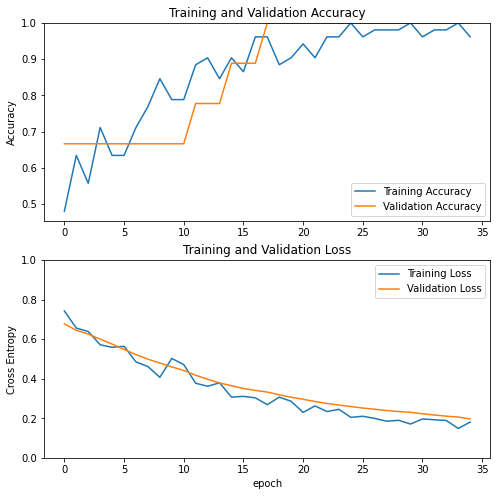

In [22]:
metrics_visualization(history)

### Fine Tuning 

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  4


In [50]:
model_fine = Custom_Model('MobileNetV2',(224,224),trainable = True)

In [51]:
model_fine = model_fine.forward()

In [52]:
# Fine-tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_fine.layers[:fine_tune_at]:
  layer.trainable = False

In [53]:
base_learning_rate = 0.0001
model_fine.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [54]:
model_fine.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [55]:
fine_tune_epochs = 10
total_epochs =  35 + fine_tune_epochs
history_fine = model_fine.fit(train_generator,epochs=total_epochs, initial_epoch=history.epoch[-1],validation_data=val_generator,class_weight=class_weights, callbacks=[checkpointer, earlystopping])

Epoch 35/45
7/7 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6731
Epoch 35: val_loss did not improve from 0.19637
7/7 [==============================] - 11s 316ms/step - loss: 0.6593 - accuracy: 0.6731 - val_loss: 0.2980 - val_accuracy: 1.0000
Epoch 36/45
7/7 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.9038
Epoch 36: val_loss did not improve from 0.19637
7/7 [==============================] - 1s 106ms/step - loss: 0.3758 - accuracy: 0.9038 - val_loss: 0.2232 - val_accuracy: 1.0000
Epoch 37/45
7/7 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.9231
Epoch 37: val_loss improved from 0.19637 to 0.15251, saving model to /content/drive/MyDrive/Bilberry/first_training.hdf5
7/7 [==============================] - 2s 295ms/step - loss: 0.2718 - accuracy: 0.9231 - val_loss: 0.1525 - val_accuracy: 1.0000
Epoch 38/45
7/7 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9615
Epoch 38: val_loss impr

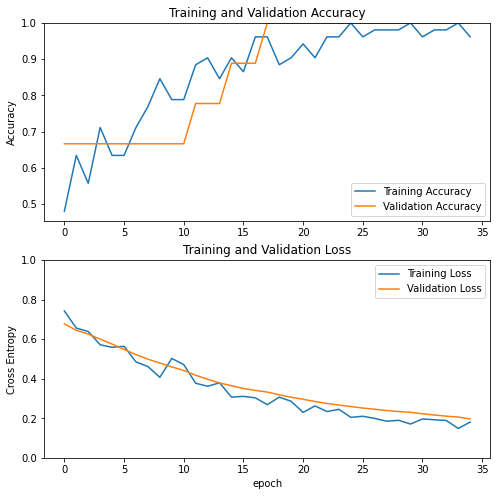

In [56]:
metrics_visualization(history)

## Evaluation and Prediction


In [57]:
y_true = test_generator.classes
predict = model_fine.predict_generator(test_generator)
y_pred = np.argmax(predict, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


True Negatives:  9
False Positives:  0
False Negatives:  0
True Positives:  5
_______________________________________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



<function matplotlib.pyplot.show>

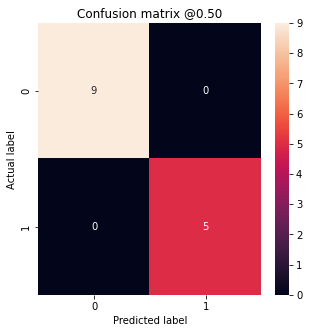

In [58]:
# plotting confusion matrix and classfication report
plot_cm(y_true,y_pred)

### Prediction on New External Data

In [61]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())

from tensorflow.keras.preprocessing import image
def external_test(img_pth):

  img = image.load_img(
      img_pth, target_size=(224, 224)
  )
  plt.imshow(img)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = img_array / 255.
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model_fine.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

This image most likely belongs to roads with a 69.99 percent confidence.


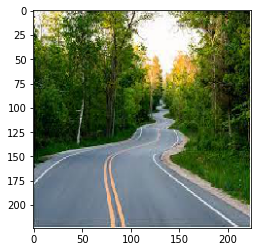

In [66]:
road_path = "/content/road.jpg"
field_path = "/content/field.jpg"
road_path_1 = "/content/road_1.jpg"
field_path_1 = "/content/field_1.jpg"

external_test(road_path)

This image most likely belongs to fields with a 70.85 percent confidence.


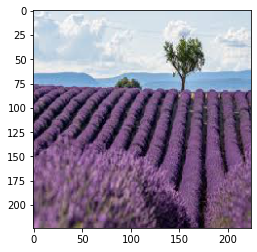

In [67]:
external_test(field_path)


This image most likely belongs to roads with a 69.05 percent confidence.


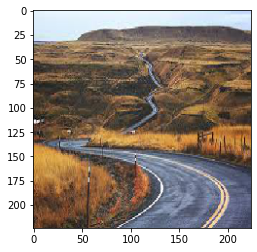

In [68]:
external_test(road_path_1)

This image most likely belongs to fields with a 71.93 percent confidence.


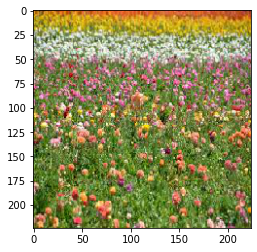

In [69]:
external_test(field_path_1)